# Visually confirming that graphs are generated correctly using the package network methods

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import sys       
import igraph               

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

from wfqc.network import *

## Creating an example network with the attributes of our network

To mimic the setup of the actual data the example network has nodes that are tools, named TA, TB etc, and nodes that are citations of these tools, named CA, CB etc. Tools can cite eacother, and tools can also cite themselves, creating self loops. Citations do not cite other citations. There are fully disconnected tools in this network, that are not connected to any other tool. These discoonected tools can have many citations, or none, but are not connected to the rest of the network. Some of the disconnected tools have self loops. There are subclusters that are disconnected from eachother. Edges are not necessarily unique; the same connection can occur twice in the same network. Some citations are connected to almost all tools. 

#### Creating the edges

In [2]:
# The network

# Define the nodes 
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'),

    # Citations to multiple tools
    ('CC', 'TA'), ('CC', 'TC'),  
    ('CD', 'TA'), ('CD', 'TC'),

    # Tools citing each other
    ('TC', 'TD'), 

    # Duplicate edges
    ('CE', 'TF'), ('CE', 'TF'),

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CF', 'TE'), ('CF', 'TF')
]


#### Create graph

In [3]:
raw_graph = igraph.Graph.TupleList(edges, directed=True)

included_tools = [tool for tool in raw_graph.vs['name'] if tool in tools]  
cocitation_graph = create_cocitation_graph(raw_graph,included_tools)

In [4]:
cocitation_expected_nodes = ['TA', 'TC', 'TD', 'TE', 'TF']
citation_expected_nodes = ['TA', 'TC', 'TD', 'TE', 'TF', 'CC', 'CD', 'CF', ]
expected_edge_weights = {('TA', 'TC'): 2, ('TC', 'TD'): 1, ('TE', 'TF'): 1,
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection


tool_metadata = {
    "tools": [
        {'name': 'ToolnameA', 'pmid': 'TA', 'nrCitations': 1, 'pubdate': 2015},
        {'name': 'ToolnameB', 'pmid': 'TB', 'nrCitations': 2, 'pubdate': 2016}, 
        {'name': 'ToolnameC', 'pmid': 'TC', 'nrCitations': 3, 'pubdate': 2017},
        {'name': 'ToolnameD', 'pmid': 'TD', 'nrCitations': 4, 'pubdate': 2018},
        {'name': 'ToolnameE', 'pmid': 'TE', 'nrCitations': 5, 'pubdate': 2019},
        {'name': 'ToolnameF', 'pmid': 'TF', 'nrCitations': 6, 'pubdate': 2020}
    ]
}

## Visualisation


#### Preview of 'raw' graph

In [5]:
node_colours = []
for node in raw_graph.vs['name']:
    if node in included_tools:
        node_colours.append('blue')
    else:
        node_colours.append('gray')

raw_graph.vs['color'] = node_colours

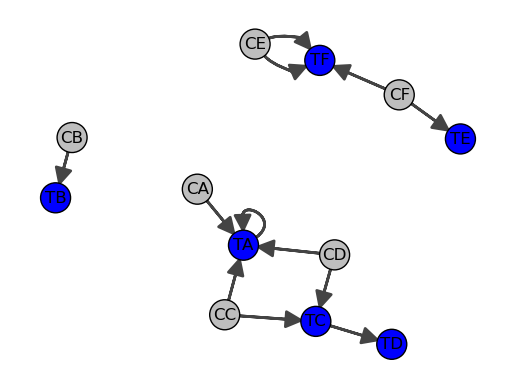

In [6]:
fig, ax = plt.subplots()
igraph.plot(raw_graph, target=ax, vertex_label = raw_graph.vs['name'])
plt.show()

#### Visually confirming that simplify works

In [7]:
simplified_citation_graph = raw_graph.simplify(multiple=True, loops=True, combine_edges=None)

node_colours = []
for node in simplified_citation_graph.vs['name']:
    if node in included_tools:
        node_colours.append('blue')
    else:
        node_colours.append('gray')

simplified_citation_graph.vs['color'] = node_colours

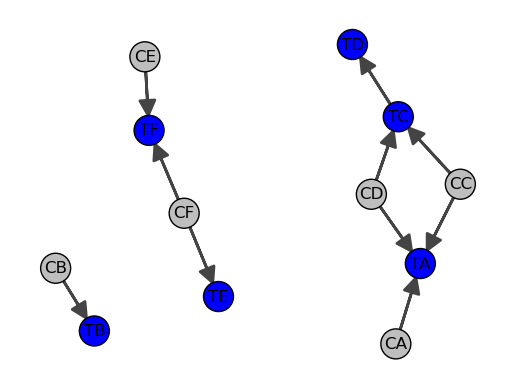

In [8]:
fig, ax = plt.subplots()
igraph.plot(simplified_citation_graph, target=ax, vertex_label=simplified_citation_graph.vs['name'])

#### Visually confirming the create_graph function
We want a graph where only chared citation nodes are left, essentially a bipartite graph, though I am allowing citationd between tools 

In [9]:
citation_graph = create_graph(edges, included_tools, cocitation=False)


11 unique out of 12 edges total!
Removed 1 self loops and multiples of edges.
Removed 4 disconnected tools and citations (with degree less or equal to 1) in the 'bipartite' graph.
Number citation of vertices removed with degree threshold 20: 0
Number of remaining tools vertices is 5, total number of vertices is 8


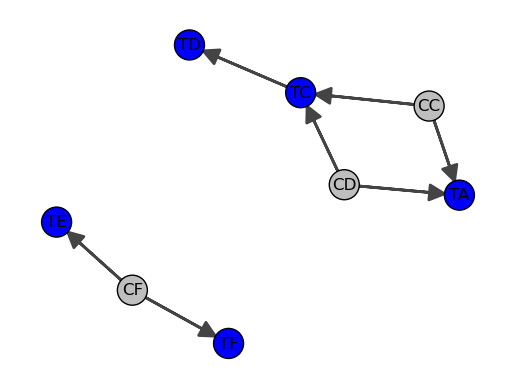

In [10]:
node_colours = []
for node in citation_graph.vs['name']:
    if node in included_tools:
        node_colours.append('blue')
    else:
        node_colours.append('gray')

citation_graph.vs['color'] = node_colours

fig, ax = plt.subplots()
igraph.plot(citation_graph, target=ax, vertex_label=citation_graph.vs['name'])


#### Visually confirming cocitation_graph function

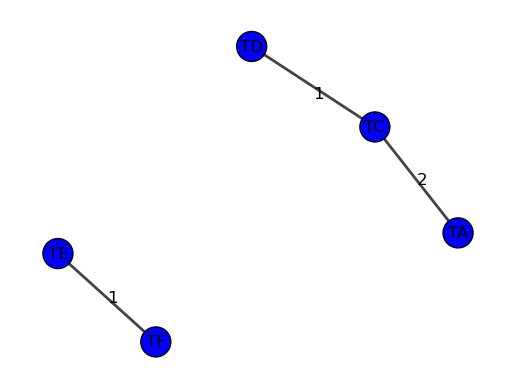

In [11]:
cocitation_graph.vs['color'] = 'blue'

# Plot the graph
fig, ax = plt.subplots()
igraph.plot(cocitation_graph, target=ax, vertex_color='blue', edge_label=cocitation_graph.es['weight'], vertex_label=cocitation_graph.vs['name'])
plt.show()


In [12]:
nodes_in_final_network = ['TA', 'TC', 'TD', 'TE', 'TF']
expected_edge_weights = {('TA', 'TC'): 2, ('TC', 'TD'): 1, ('TE', 'TF'): 1,
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection

### Illustrating that adding attributes to edges and vertices works

In [13]:
cocitation_graph = add_graph_attributes(graph=cocitation_graph, metadata_file=tool_metadata)

In [14]:
print(cocitation_graph.vs.attributes())

['name', 'color', 'tool_name', 'age', 'nr_citations']


In [15]:
print(cocitation_graph.vs['age'])

[100, 100, 100, 100, 100]
